In [1]:
#INITIALIZE SPARK SESSION
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("PodPres").getOrCreate()

assembled_df = spark.read.parquet("final_features_human_labels.parquet")
assembled_df.printSchema()
assembled_df.show()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/12 20:57:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/12 20:57:51 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


root
 |-- segment_id: long (nullable = true)
 |-- podcast_name_cleaned: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: string (nullable = true)

+----------+--------------------+--------------------+-----+
|segment_id|podcast_name_cleaned|            features|label|
+----------+--------------------+--------------------+-----+
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.8|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.5|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.8|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|    1|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.7|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.2|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.4|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.5|
|         1|    pod save america|[10.0,-0.01585099...|  0.5|
|         1|    pod save america|[10.0,-0.01585099...|  0.7|
|         1|    pod save america

In [2]:
# total row
row_count = assembled_df.count()

print(f"The DataFrame has {row_count} rows.")

The DataFrame has 867 rows.


In [3]:
from pyspark.sql.functions import rand

# shuffle
shuffled_df = assembled_df.repartition("features")  
shuffled_df = shuffled_df.orderBy(rand())


In [4]:
from pyspark.sql.functions import when, col
from pyspark.ml.classification import RandomForestClassifier

# Filter out rows where the label is exactly 0.5
shuffled_df = shuffled_df.filter(col("label") != 0.5)

# define the binary label
shuffled_df = shuffled_df.withColumn(
    "binary_label",
    when(col("label") > 0.5, 1).otherwise(0)
)

In [5]:
#split data
train_data, test_data = shuffled_df.randomSplit([0.8, 0.2], seed=42)

# Classify using RandomForest with parameters: numTrees: 20, maxDepth: 5, maxBins: 32
rf = RandomForestClassifier(featuresCol='features', labelCol='binary_label')

# Train the model
rfModel = rf.fit(train_data)

# Model evaluation
predictions = rfModel.transform(test_data)
predictions.select("binary_label", "prediction", "probability").show(truncate=False)

+------------+----------+----------------------------------------+
|binary_label|prediction|probability                             |
+------------+----------+----------------------------------------+
|1           |1.0       |[0.4973169933086418,0.5026830066913581] |
|0           |1.0       |[0.3836159225302074,0.6163840774697926] |
|1           |1.0       |[0.3836159225302074,0.6163840774697926] |
|1           |1.0       |[0.3836159225302074,0.6163840774697926] |
|1           |0.0       |[0.6133238725152552,0.3866761274847448] |
|0           |1.0       |[0.49319901009770784,0.5068009899022922]|
|1           |0.0       |[0.5248612831205302,0.47513871687946974]|
|0           |0.0       |[0.563259822997034,0.43674017700296586] |
|0           |1.0       |[0.3410482578474862,0.6589517421525137] |
|0           |1.0       |[0.3410482578474862,0.6589517421525137] |
|0           |1.0       |[0.3410482578474862,0.6589517421525137] |
|0           |1.0       |[0.3410482578474862,0.658951742152513

In [6]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="binary_label", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "precisionByLabel"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "recallByLabel"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


24/05/12 20:58:06 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Accuracy: 0.47368421052631576
Precision: 0.5178571428571429
Recall: 0.46774193548387094
F1 Score: 0.4746573676100884


In [7]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

# Convert the DataFrame to RDD and ensure that label and prediction are of float type
predictionAndLabels = predictions.select("prediction", "binary_label").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

# confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:\n", confusion_matrix)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
 [[29. 33.]
 [27. 25.]]


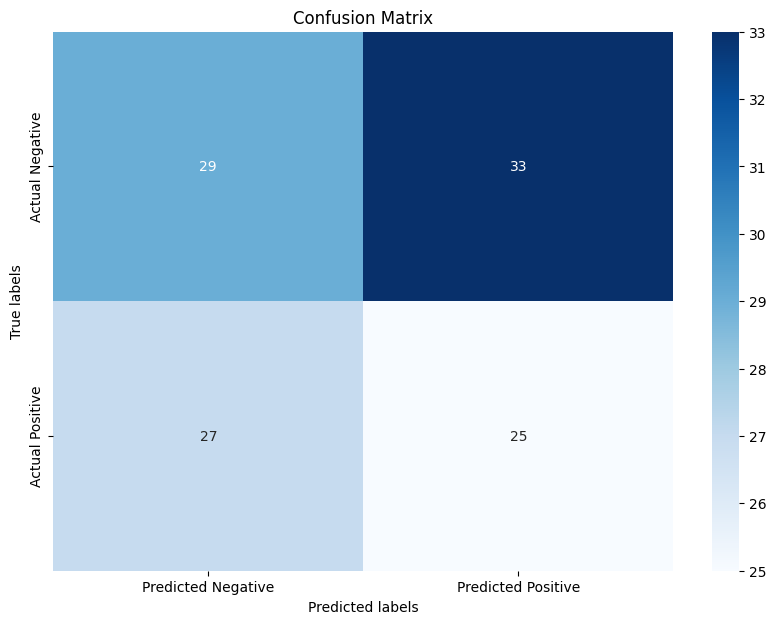

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'confusion_matrix' is already defined as a NumPy array
# For example:
# confusion_matrix = np.array([[10, 2], [1, 15]])

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [9]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# 准备数据
predictionAndLabels = predictions.select('prediction', 'binary_label').rdd.map(lambda r: (float(r[0]), float(r[1])))

# 初始化 BinaryClassificationMetrics 对象
metrics = BinaryClassificationMetrics(predictionAndLabels)

# AUC 的计算
auc = metrics.areaUnderROC
print("AUC:", auc)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


AUC: 0.4742555831265509


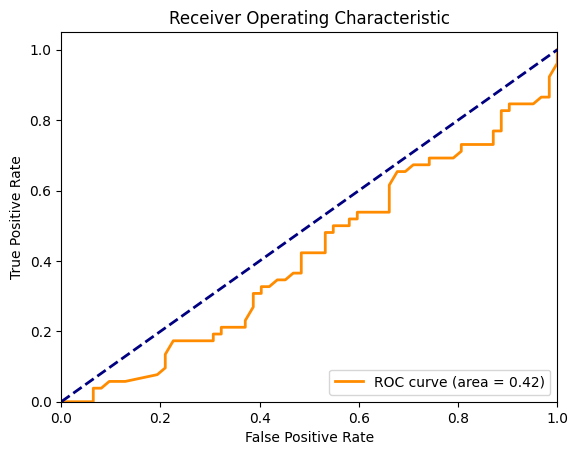

In [10]:
# 将预测结果导出为 Pandas DataFrame
predictions_pd = predictions.select("probability", "binary_label").toPandas()

# 计算不同阈值下的 TPR 和 FPR
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 提取概率预测（假定模型输出二元概率）
y_true = predictions_pd['binary_label']
y_scores = predictions_pd['probability'].apply(lambda x: x[1])

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [11]:
from pyspark.sql.functions import udf, col, lit
from pyspark.sql.types import DoubleType

# Define a UDF to extract elements from a vector
def extract_probability_element(prob_vector, index):
    return float(prob_vector.values[index])

# Register the UDF
extract_probability_udf = udf(extract_probability_element, DoubleType())

# Use the UDF to extract Biden and Trump probabilities
predictions = predictions.withColumn("prob_biden", extract_probability_udf(col("probability"), lit(0)))
predictions = predictions.withColumn("prob_trump", extract_probability_udf(col("probability"), lit(1)))
predictions.select("prob_biden", "prob_trump").show()
# Now calculate the averages
average_probs = predictions.agg(
    {"prob_biden": "avg", "prob_trump": "avg"}
).collect()[0]

avg_prob_biden = average_probs["avg(prob_biden)"]
avg_prob_trump = average_probs["avg(prob_trump)"]

print(f"Average Trump win probability: {avg_prob_trump*100:.2f}%")
print(f"Average Biden win probability: {avg_prob_biden*100:.2f}%")



+-------------------+-------------------+
|         prob_biden|         prob_trump|
+-------------------+-------------------+
| 0.4973169933086418| 0.5026830066913581|
| 0.3836159225302074| 0.6163840774697926|
| 0.3836159225302074| 0.6163840774697926|
| 0.3836159225302074| 0.6163840774697926|
| 0.6133238725152552| 0.3866761274847448|
|0.49319901009770784| 0.5068009899022922|
| 0.5248612831205302|0.47513871687946974|
|  0.563259822997034|0.43674017700296586|
| 0.3410482578474862| 0.6589517421525137|
| 0.3410482578474862| 0.6589517421525137|
| 0.3410482578474862| 0.6589517421525137|
| 0.3410482578474862| 0.6589517421525137|
| 0.3410482578474862| 0.6589517421525137|
|0.32518312147623624| 0.6748168785237638|
|0.32518312147623624| 0.6748168785237638|
|0.31630261546826155| 0.6836973845317383|
| 0.5818585636326559| 0.4181414363673441|
| 0.2611519776459014| 0.7388480223540985|
| 0.4969385767999472| 0.5030614232000529|
|  0.484285963341425| 0.5157140366585751|
+-------------------+-------------